In [2]:
import astropy
from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind

File = "data/m-sig_table_con_tc.csv"
data = ascii.read(File)
#with fits.open("Arthur/AGN.fits") as data2:
with fits.open("Data/AGN_V1.fits") as data2:
    data2.info()
    data_AGN_BH = data2[0].data[2]
    data_AGN_SI = data2[0].data[3]
print(data_AGN_BH)
#data_AGN_BH = 10**(data_AGN_BH)





data_by_type = data.group_by("Type")

early_type = data_by_type.groups[0:9]
late_type = data_by_type.groups[9:18]

Filename: Data/AGN_V1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (87860, 4)   float64   
[1.75792361e+10 4.08225378e+10 2.18072047e+10 ... 4.32912375e+10
 1.08392691e+11 1.36050455e+11]


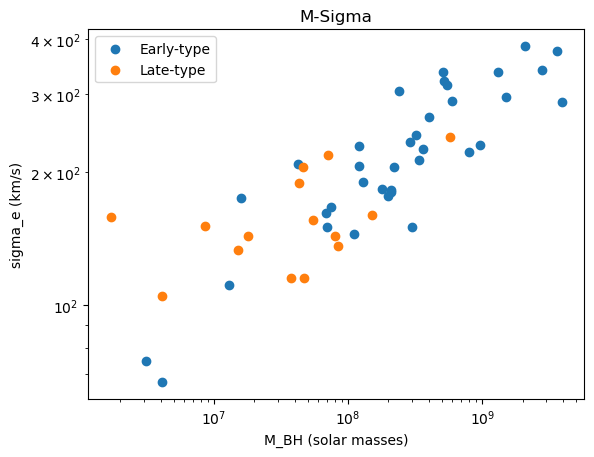

In [3]:
y="sigma_e (km/s)"
x="M_BH (solar masses)"

plt.scatter(early_type[x], early_type[y], label="Early-type")
plt.scatter(late_type[x], late_type[y], label="Late-type")
    
plt.xscale('log')
plt.yscale('log')
plt.title("M-Sigma")
plt.legend()
plt.xlabel(x)
plt.ylabel(y)
plt.show()

The M-$\sigma$ relation, a linear in log-log-space relation between the mass of the central Supermassive Blach Hole and the velocity dispersion of the bulge stars. This relation holds for both early- and late-type galaxies.

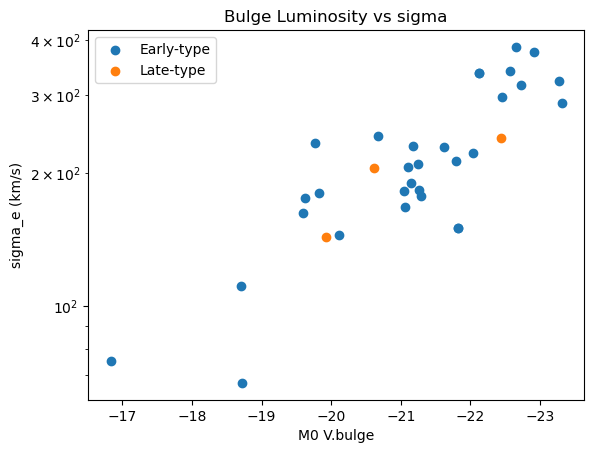

In [5]:
y="sigma_e (km/s)"
x="M0 V.bulge"


plt.scatter(early_type[x], early_type[y], label="Early-type")
plt.scatter(late_type[x], late_type[y], label="Late-type")
    
plt.yscale('log')
plt.gca().invert_xaxis()
plt.title("Bulge Luminosity vs sigma")
plt.legend()
plt.xlabel(x)
plt.ylabel(y)

plt.show()

Interestingly, there also seems to be a log-log-linear realtion between Bulge luminosity and Black Hole mass, though we only have enough data for early-type galaxies. 3 data points for late types is not enough to make statistical statements with any certainty.

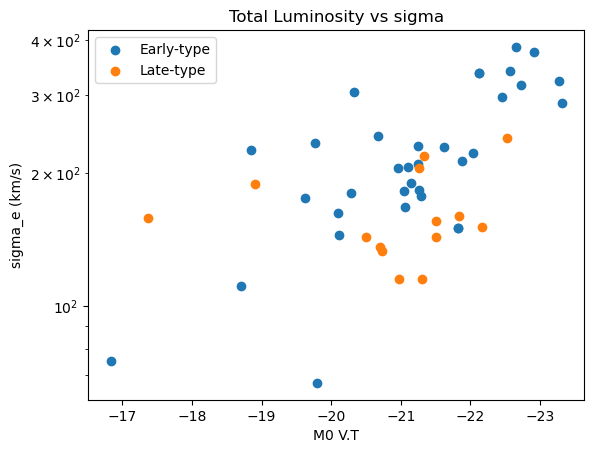

In [7]:
y="sigma_e (km/s)"
x="M0 V.T"


plt.scatter(early_type[x], early_type[y], label="Early-type")
plt.scatter(late_type[x], late_type[y], label="Late-type")
    
plt.yscale('log')
plt.gca().invert_xaxis()
plt.title("Total Luminosity vs sigma")
plt.legend()
plt.xlabel(x)
plt.ylabel(y)

plt.show()

Looking at the total luminosity versus the Blach Hole mass doesnt seem to have much correlation. The spread is way more pronounced than in the previous plots.

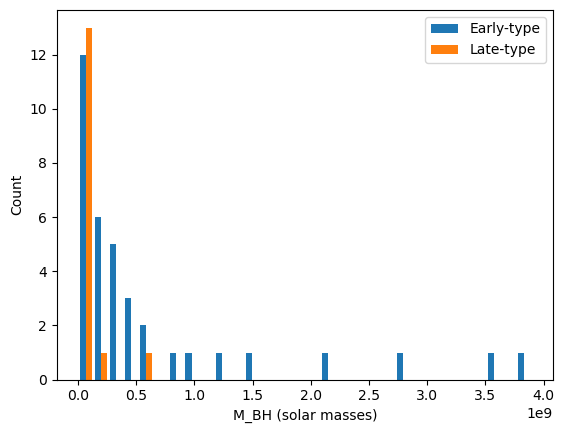

In [9]:
x = "M_BH (solar masses)"

plt.hist((early_type[x], late_type[x]), label = ("Early-type", "Late-type"), bins = 30)

plt.legend()
plt.xlabel(x)
plt.ylabel("Count")
plt.show()

A histogram of Black Hole masses, as can be seen, early-type galaxies have a very spread out distribution of BH masses, with a trailing off tail towards higher masses.

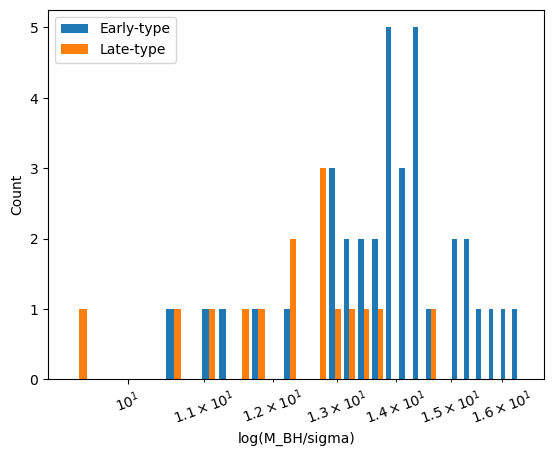

In [11]:
x = "M_BH (solar masses)"
y = "sigma_e (km/s)"

plt.hist((np.log(early_type[x]/early_type[y]), np.log(late_type[x]/late_type[y])), label = ("Early-type", "Late-type"), bins = 30)
plt.xscale("log")

plt.legend()
plt.tick_params(axis = "x", which = "both", labelrotation = 20)
plt.xlabel("log(M_BH/sigma)")
plt.ylabel("Count")
plt.show()

Taking a look at the distribution of Black Hole masses divided by $\sigma$, surprisingly the early-types almost look to be lognormal distributed. We havent yet checked wether they actually are in a lognormal distribution, nor do we know if this is physically relevant, but this definetly warrants a closer look.

54.598150033144236


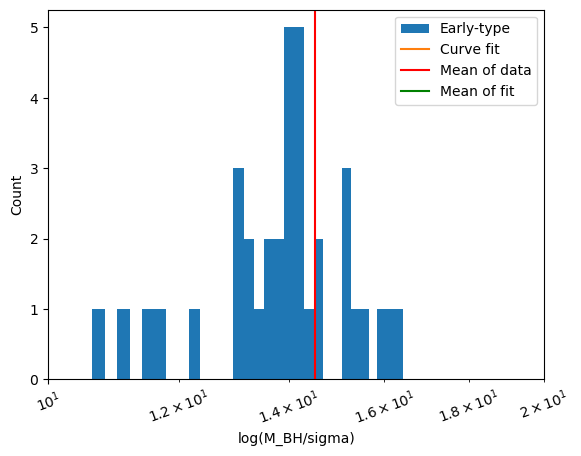

In [13]:
x = "M_BH (solar masses)"
y = "sigma_e (km/s)"
def logfunc(x, mu, sigma):
    return (1/((x)*np.sqrt(2*np.pi*(sigma**2))))*np.exp((-(np.log(x)-mu)**2)/(2*(sigma**2)))
bins = 30
plt.hist(np.log((early_type[x]/early_type[y])), label = "Early-type", bins = bins)
y_data, x_data = np.histogram((early_type[x]/early_type[y]), bins = bins) #This should not be a log, but the fit doesnt give me anything if it isnt
plt.xscale("log")
#print((y_data), (x_data))

popt, pcov = curve_fit(logfunc, x_data[:-1], y_data)
plt.plot((x_data), (logfunc(x_data, popt[0], popt[1])), label = "Curve fit")
plt.axvline(np.log(np.average(a = x_data[:-1], weights = y_data)), color = "r", label = "Mean of data")
plt.axvline(np.exp(popt[0]), color = "g", label = "Mean of fit")

#print(np.exp(2*popt[0]+(popt[1]**2))*(np.exp(popt[1])-1))
#print(np.exp(popt[1])**2)
print(np.exp(2*popt[0]+2*(popt[1]**2)))

plt.legend()
plt.tick_params(axis = "x", which = "both", labelrotation = 20)
plt.xlabel("log(M_BH/sigma)")
plt.ylabel("Count")
plt.xlim(10, 20)
plt.show()


Because fitting a lognormal function to the above distribution did not work, it seems likely that the data is not lognormal distributed, but merely appeared that way due to the chosen bin size of the histogram.

Mean of Data:  3.4929844904021953e-07
Variance of Data:  4.1944211211023353e-13
2-sigma confidence interval for mean: (1.6792198817038843e-07, 5.306749099100506e-07)
5-sigma confidence interval for mean: (-1.0414270313435821e-07, 8.027396012147973e-07)


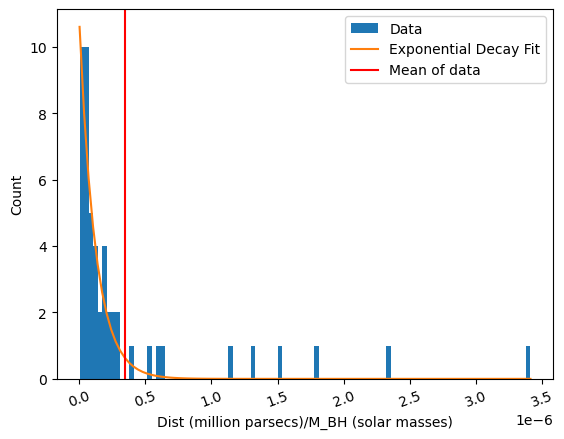

In [15]:
x = "Dist (million parsecs)"
y = "M_BH (solar masses)"

bins = 100

plt.hist((data[x]/data[y]), label = "Data", bins = bins)
y_data, x_data = np.histogram((data[x]/data[y]), bins = bins)

def exp_decay(x, N_0, lam):
    return N_0*np.exp(-lam*x)
popt, pcov = curve_fit(exp_decay, x_data[:-1], y_data)
plt.plot(x_data, exp_decay(x_data, popt[0], popt[1]), label = "Exponential Decay Fit")
#print(popt)

mean = np.sum(data[x]/data[y])/len(data[x]/data[y])
var = np.sum((data[x]/data[y])**2)/len(data[x]/data[y])-mean**2
print("Mean of Data: ", mean)
print("Variance of Data: ", var)
plt.axvline(mean, color = "r", label = "Mean of data")

two_sig_conf = (mean-2*(np.sqrt(var/len(data[x]/data[y]))), mean+2*(np.sqrt(var/len(data[x]/data[y]))))
five_sig_conf = (mean-5*(np.sqrt(var/len(data[x]/data[y]))), mean+5*(np.sqrt(var/len(data[x]/data[y]))))
print("2-sigma confidence interval for mean:", two_sig_conf)
print("5-sigma confidence interval for mean:", five_sig_conf)

plt.legend()
plt.tick_params(axis = "x", which = "both", labelrotation = 20)
plt.xlabel("Dist (million parsecs)/M_BH (solar masses)")
plt.ylabel("Count")
plt.show()

Distance over Black Hole mass almost certainly doesnt follow a physically relevant distribution, unless you look at Black Holes billions of parsecs away, as you would be looking into the early universe. It does however follow a instrument related distribution. To get good data of Black Holes far away, you need to look at bigger, and therefor more massive Black Holes. Distance/Black Hole mass should therefor be almost constant, and as can be seen in the distribution above, most values lie very close together, with only a few outliers to the left at higher distances compared to Black Hole mass. Additionally, as seen in the plots below, most of the data points for both distance and Blck Hole mass have similar values in the first place, so their combined quantitiy following the above distribution is expected.

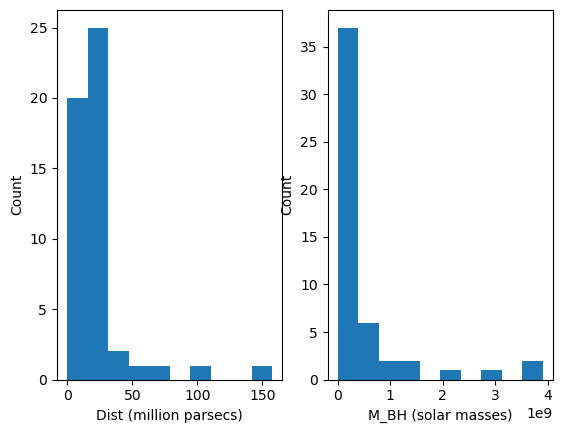

In [17]:
x = "Dist (million parsecs)"
y = "M_BH (solar masses)"

plt.subplot(121)
plt.hist(data[x])
plt.xlabel("Dist (million parsecs)")
plt.ylabel("Count")

plt.subplot(122)
plt.hist(data[y])
plt.xlabel("M_BH (solar masses)")
plt.ylabel("Count")

plt.show()

We have two Black Hole mass samples, one from our paper ($\mu_1$) and one from the AGN catalog ($\mu_2$). We test wether these samples have the same mean BH mass. \
$H_0$: $\mu_1 = \mu_2$ \
$H_a$: $\mu_1 \neq \mu_2$


In [19]:
testIndex = data_AGN_BH.sort()

Mean 1: 4.787e+08
Mean 2: 8.218e+10
Standard deviation 1: 2.271e+09
Standard deviation 2: 1.385e+12
t-value: -17.44942478499876
95% Confidence Interval: (-9.088e+10, -7.252e+10)


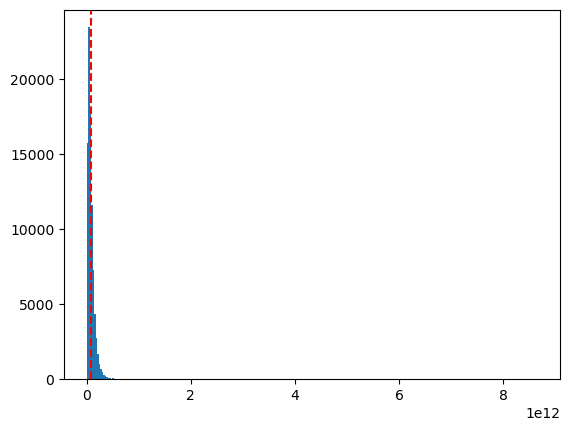

8661637419723.033


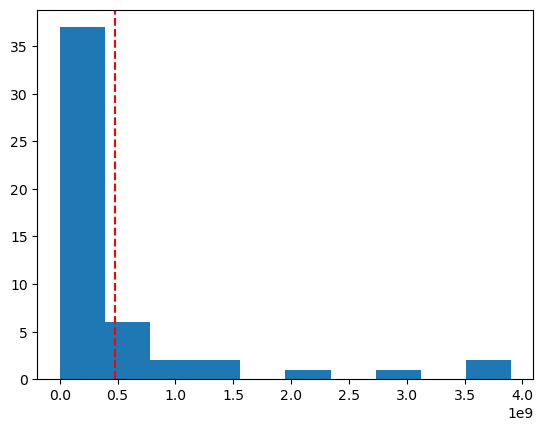

TtestResult(statistic=-275.31503919784916, pvalue=0.0, df=1831.6154563206233)

In [20]:
mbh = "M_BH (solar masses)"

# Means for both data sets
mean_data1 = np.sum(data[mbh])/len(data[mbh])
mean_data2 = np.sum(data_AGN_BH)/len(data_AGN_BH)

#print(np.sum(data_AGN_BH))
#print(len(data_AGN_BH)**0.5)
#print(np.sum((data_AGN_BH-mean_data2)**2))


# Standard deviation for both data sets
std_data1 = np.sum((data[mbh]-mean_data1)**2)/((len(data[mbh]))**0.5)
std_data2 = np.sum((data_AGN_BH-mean_data2)**2)/((len(data_AGN_BH))**0.5)

std_data1 = std_data1**(1/2)
std_data2 = std_data2**(1/2)
#print("Mean 1:", mean_data1)
#print("Mean 2:", mean_data2)
#print("Standard deviation 1:", std_data1)
#print("Standard deviation 2:", std_data2)

print(f"Mean 1: {mean_data1:.3e}")
print(f"Mean 2: {mean_data2:.3e}")

print(f"Standard deviation 1: {std_data1:.3e}")
print(f"Standard deviation 2: {std_data2:.3e}")

# The t-value, for "case 2" in the lecture notes, large sample sizes with population standard deviations
T = (mean_data1 - mean_data2)/(np.sqrt(std_data1**2/len(data[mbh])+std_data2**2/len(data_AGN_BH)))
print("t-value:", T)

# 95% Confidence interval, has to contain 0 for means to not be different

lower = (mean_data1 - mean_data2)-1.96*np.sqrt(((std_data1**2)/len(data[mbh]))+((std_data2**2)/len(data_AGN_BH)))
upper = (mean_data1 - mean_data2) + 1.96*np.sqrt((std_data1**2/len(data[mbh]))+(std_data2**2/len(data_AGN_BH)))
#print("95% Confidence Interval:", (lower, upper))
print(f"95% Confidence Interval: ({lower:.3e}, {upper:.3e})")



plt.hist(data_AGN_BH, bins = 300)
plt.axvline(mean_data2, color = "r", label = r"$\mu$", linestyle="--")

plt.show()
print(max(data_AGN_BH))
plt.hist(data[mbh])
plt.axvline(mean_data1, color = "r", label = r"$\mu-\sigma$", linestyle="--")

plt.show()

ttest_ind(data[mbh], data_AGN_BH, equal_var = False)

As it turns out, the two means of these samples are so far apart, our p-value is zero, and our 95% confidence interval is 11 orders of magnitude away from zero.

Firstly the correlation coefficient $r=\rho$ were calculated, to know if a correlation can be assumed or not:
$$ r = \frac{\sum{}(x_i-\overline{x})(y_i-\overline{y})}{\sqrt{sum{}(x_i-\overline{x})^2(y_i-\overline{y})^2}}$$

r can be between -1 and 1. If the R=0, than no relation can be assumed. The greater the absolute value is, the greater the correlation. -1 is for a negativ slope and +1 for a positv slope.

With the r a t-test can be calculated (for a data set of n data points): 
$$ t= \frac{r\sqrt{n-2}}{\sqrt{1-r^2}} $$

To get the p-value, it is "necessary" to look at at table or calculate it with a computer. 

The calculations were done with scipy.stats.pearsonr

In [23]:
from scipy.stats import pearsonr

x = "sigma_e (km/s)"
y = "M_BH (solar masses)"

nData = {"Early": [np.log(early_type[x])/np.log(10), np.log(early_type[y])/np.log(10)],
        "Late"  : [np.log(late_type[x])/np.log(10), np.log(late_type[y])/np.log(10)],
        "AGN"   : [np.log(data_AGN_SI)/np.log(10), np.log(data_AGN_BH)/np.log(10)],    
        "Gütel" : [np.log(data["sigma_e (km/s)"])/np.log(10), np.log(data["M_BH (solar masses)"])/np.log(10)]}

r = {}
p_value = {}
for i, v in enumerate(nData):
    rr, p = pearsonr(nData[v][0], nData[v][1])
    r[v] = rr
    p_value[v] = p

    temp = "rejected"
    if p_value[v] <= 0.05:
        temp = "not rejected"
    print(f"{v}: {temp}")
    print(f"r={r[v]:.3f}")
    print(f"p={p_value[v]*100:.3f}%\n")


Early: not rejected
r=0.880
p=0.000%

Late: rejected
r=0.480
p=7.010%

AGN: not rejected
r=-0.008
p=2.508%

Gütel: not rejected
r=0.836
p=0.000%



With a signifcant level of 95%, only the late types can be rejected. But for the AGN the r value is very small, thefore the probabilty, if there is a realtionship is very low. 

In the next section the linear regression is done. For that statsmodels.api were used. This libary do the linear regression, and also calulates values. For the Linear Regression the following equation were used:
$$ \log \left( \frac{M}{M_\odot} \right) = \alpha + \beta \log \left( \frac{\sigma}{200} \right) $$

This equation were taken, to compare our results with the litature. For right use of the varaible, it is necessary to remove $\log 200$ from $$\log sig$$.  

The value bse of the libaray is the standard Error and can be calculated as followed: 
$$ SE(\hat{\beta_i}) = \sqrt{\hat{\sigma^2}(X^TX)_{ii}^{-1}} $$

$\beta_i$ are the coeffeicents, X is a matrix and $\sigma^2$ is the resedium error. 

In [25]:
import statsmodels.api as sm

fitData_WTF = [nData[v][0]-np.log(200)/np.log(10) for v in nData]
results = []

RESULT = []

for i, v in enumerate(nData):
    fitData_WTF[i] = sm.add_constant(fitData_WTF[i])
    model = sm.OLS(nData[v][1], fitData_WTF[i])
    results.append(model.fit())
    
    #print(results[-1].summary())
    #print("\n+++++++++++++++n")

    RESULT.append((results[-1].params[1], results[-1].params[0]))
    print(v, ": ", RESULT[-1])
    #print("\n*******************\n")
    

Early :  (3.681791835961753, 8.268713419114157)
Late :  (2.8814894232838784, 7.871385987227784)
AGN :  (-0.016870899007623813, 10.776328192798687)
Gütel :  (3.912371660618305, 8.182590754023773)


-2215.764392118171
-739.7566147876462
-9261642.811168352
-2948.386822223382


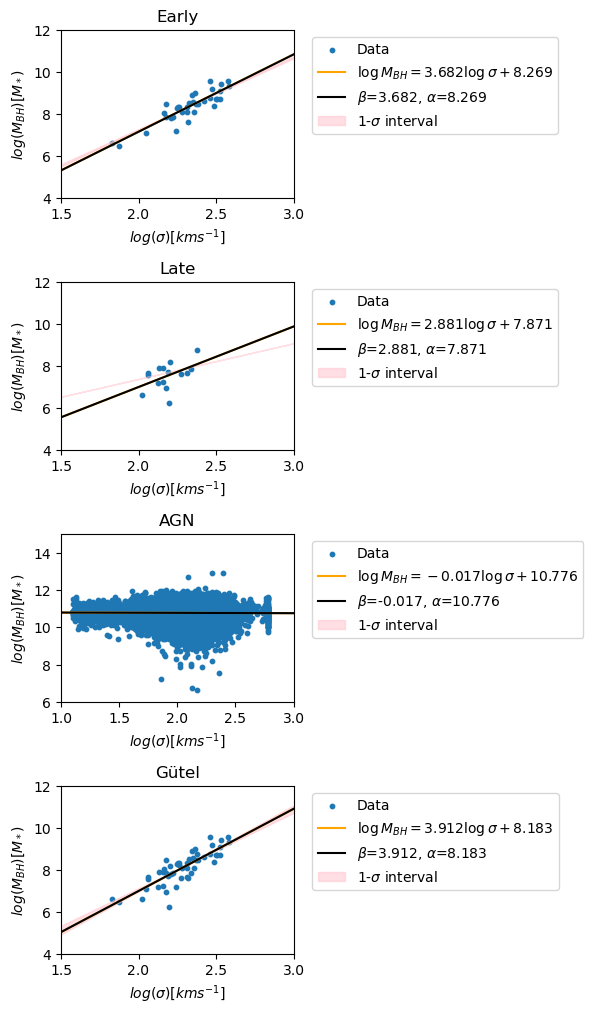

Early
Standard error: 0.341, 0.060,
Covariance = 0.416
Pearson = 0.880
Pearson new= 0.880
Bootstrap: min: 3.364, max: 3.498, normal: 3.682
Residiun: min: 7.214, max: 8.805, mean: 8.066
Standard error (new): a+-0.453, b+-0.674
Mean Residiun = 8.066
Late
Standard error: 1.460, 0.223,
Covariance = 0.091
Pearson = 0.480
Pearson new= 0.480
Bootstrap: min: 1.699, max: 1.699, normal: 2.881
Residiun: min: 7.766, max: 9.769, mean: 9.112
Standard error (new): a+-0.771, b+-1.383
Mean Residiun = 9.112
AGN
Standard error: 0.008, 0.002,
Covariance = 0.000
Pearson = 0.008
Pearson new= -0.008
Bootstrap: min: -0.025, max: -0.020, normal: -0.017
Residiun: min: 17.475, max: 23.753, mean: 21.591
Standard error (new): a+-0.015, b+-0.043
Mean Residiun = 21.591
Gütel
Standard error: 0.368, 0.062,
Covariance = 0.439
Pearson = 0.836
Pearson new= 0.836
Bootstrap: min: 3.584, max: 4.101, normal: 3.912
Residiun: min: 5.811, max: 8.152, mean: 7.363
Standard error (new): a+-0.359, b+-0.494
Mean Residiun = 7.363


In [93]:
#Plotting
import matplotlib.pyplot as plt

def Covariance(X, Y):
    Mx = Mean(X)
    My = Mean(Y)
    return np.sum((X-Mx)*(Y-My))/(len(X)-1)

def Pearson(cov, sigX, sigY):
    return cov/(sigX*sigY)

def Mean(X):
    return np.sum(X)/len(X)

def Sig(X):
    return (np.sum((X-Mean(X))**2)/(len(X)-1))**0.5

#bootstrap
def Slope(X, Y):
    X_mean = Mean(X)
    Y_mean = Mean(Y)
    return np.sum((X - X_mean) * (Y - Y_mean))/np.sum((X - X_mean) ** 2)

fit  = lambda k, d, x: k*x+d-k*np.log(200)/np.log(10)
x_values = np.logspace(-1, 1, 100)
fig, axs = plt.subplots(4, 1, figsize=(3, 12))

plt.subplots_adjust(hspace=0.5)

limits = {"Early": {"x": (1.5, 3), "y": (4,12)},
          "Late" : {"x": (1.5, 3), "y": (4,12)},
          "AGN"  : {"x": (1, 3),   "y": (6,15)},
          "Gütel": {"x": (1.5, 3), "y": (4,12)}}

cov = {}
per = {}

k = 100
alpha = 1-0.683

slopy = {} #y is 
slopyS = {}
minSlopy = {}
maxSlopy = {}
norSlopy = {}

residiun = {}
varRe = {}
SE = {}
for i, v in enumerate(nData):
    funcText = rf"$\log M_{{BH}}={RESULT[i][0]:.3f}\log{{\sigma}}+{RESULT[i][1]:.3f}$"

    axs[i].scatter(nData[v][0], nData[v][1], label="Data", s=10)
    axs[i].plot(x_values, fit(RESULT[i][0], RESULT[i][1], x_values), label=funcText, color="orange")

    # bootstrap
    slopy[v] = []
    # bootstrap
    for j in range(k):
        ii = np.random.choice(len(nData[v][0]), size=len(nData[v][0]), replace=True)
        x_temp = nData[v][0][ii]
        y_temp = nData[v][1][ii]

        slopy[v].append(Slope(x_temp, y_temp))
    
    slopyS[v] = np.sort(slopy[v])
    minSlopy[v] = slopyS[v][int((alpha/2) * k)]
    maxSlopy[v] = slopy[v][int((1 - alpha/2) * k)]
    norSlopy[v] = Slope(nData[v][0], nData[v][1])

    offset = Mean(nData[v][1]) - norSlopy[v] * Mean(nData[v][0])+np.log(200)/np.log(10)*norSlopy[v]

    y_bootstrap = [slopy[v] * x_values + offset for slope in slopy[v]]
    y_lower = fit(minSlopy[v], offset, x_values)
    y_upper = fit(maxSlopy[v], offset, x_values)
    y_temp = fit(norSlopy[v], offset ,x_values)

    offset = Mean(nData[v][1]) - norSlopy[v] * Mean(nData[v][0])+np.log(200)/np.log(10)*norSlopy[v]

    residiun[v] = nData[v][1] - norSlopy[v]*nData[v][0]+offset
    varRe[v] = 1/(len(residiun[v])-2)*np.sum(residiun[v]) # Internet (=s^2)

    b = (varRe[v]/np.sum((nData[v][1]-Mean(nData[v][1]))**2))**0.5 # Internet
    a = (varRe[v]*(1/len(nData[v][1]) + Mean(nData[v][1])/np.sum((nData[v][1]-Mean(nData[v][1])**2))))**0.5 # Inernet            

    #Source: https://people.duke.edu/~rnau/mathreg.htm
    
    SE[v] = {"a": a, "b": b}
    
    axs[i].plot(x_values, y_temp, color='black', label=fr"$\beta$={norSlopy[v]:.3f}, $\alpha$={offset:.3f}")
    axs[i].fill_between(x_values, y_lower, y_upper, color="pink", alpha=0.5, label=fr"1-$\sigma$ interval")

   
    #Calulations
    cov[v] = Covariance(nData[v][1], fit(RESULT[i][0], RESULT[i][1], nData[v][0]))
    per[v] = Pearson(cov[v], Sig(nData[v][1]), Sig(fit(RESULT[i][0], RESULT[i][1], nData[v][0])))

    #Subpllotinfos
    axs[i].set_title(v)

    axs[i].set_xlim(limits[v]["x"][0], limits[v]["x"][1])
    axs[i].set_ylim(limits[v]["y"][0], limits[v]["y"][1])

    axs[i].set_xlabel(r"$log(\sigma) [km s^{-1}]$")
    axs[i].set_ylabel(r"$log(M_{BH}) [M_*)$")
    axs[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()

for i, v in enumerate(nData):
    print(v)
    print(f"Standard error: {results[i].bse[1]:.3f}, {results[i].bse[0]:.3f},")
    print(f"Covariance = {cov[v]:.3f}")
    print(f"Pearson = {per[v]:.3f}")
    print(f"Pearson new= {r[v]:.3f}")
    print(f"Bootstrap: min: {minSlopy[v]:.3f}, max: {maxSlopy[v]:.3f}, normal: {norSlopy[v]:.3f}")
    print(f"Residiun: min: {min(residiun[v]):.3f}, max: {max(residiun[v]):.3f}, mean: {np.sum(residiun[v])/len(residiun[v]):.3f}")
    print(f"Standard error (new): a+-{SE[v]["a"]:.3f}, b+-{SE[v]["b"]:.3f}")
    print(f"Mean Residiun = {Mean(residiun[v]):.3f}")
    print("==============")

In [83]:
residiun[v]

array([[1.67313472, 1.54316602, 2.0634032 , 1.49013619, 1.49013619,
        1.94012589, 2.20767242, 1.64122348, 1.36569738, 1.66507457,
        3.24018943, 2.25335229, 1.56876457, 1.87581683, 2.30785053,
        2.78358295, 1.33504594, 1.97628317, 2.20129056, 1.91496968,
        1.76568564, 1.47981393, 2.04656405, 2.15757062, 2.47237436,
        2.24011707, 1.93505099, 2.06907079, 2.02448401, 1.60633839,
        2.22054203, 1.96064955, 2.34325409, 3.37156092, 2.43288965,
        2.43288965],
       [8.80480684, 7.75131349, 7.82871722, 7.67007646, 8.07644964,
        7.65947165, 8.26982033, 8.34602303, 8.34796861, 7.98082782,
        7.85648986, 7.21443423, 7.81081671, 7.99715144, 7.95436578,
        7.85220333, 8.07180451, 8.53302018, 8.19411197, 8.00815182,
        7.942864  , 8.39549304, 7.34966706, 7.99276037, 8.35239904,
        8.2931738 , 8.55559439, 8.09973961, 8.22758332, 7.50224979,
        8.28748882, 8.16476953, 7.97258817, 8.15826998, 8.73391964,
        8.10189643]])